In [ ]:
!pip install pulp

import pulp
import requests
import numpy as np
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 20.2 MB/s eta 0:00:00


In [ ]:
link = 'https://data.opendatasoft.com/api/explore/v2.1/catalog/datasets/georef-united-states-of-america-zc-point@public/exports/json?lang=en&timezone=America%2FNew_York'
response=requests.get(link)
data = response.json()

#get just the entries for Michigan
mi_indices = []
for i in range(len(data)):
  if data[i]['ste_name'] == 'Michigan':
    mi_indices.append(i)

#returns the distance in km between two cities in the dataset using the haversine formula
#https://en.wikipedia.org/wiki/Haversine_formula
def dist(i,j):
  latdiff=np.radians(data[i]['geo_point_2d']['lat']-data[j]['geo_point_2d']['lat'])
  londiff=np.radians(data[i]['geo_point_2d']['lon']-data[j]['geo_point_2d']['lon'])

  a = np.sin(latdiff/2)**2 + np.cos(np.radians(data[i]['geo_point_2d']['lat'])
                                     ) * np.cos(np.radians(data[j]['geo_point_2d']['lat'])) * np.sin(londiff/2)**2
  c = 2 * np.arctan2(np.sqrt(a),  np.sqrt(1-a))
  return 6371 * c

In [ ]:
num_cities = 15              #set number of cities

#to generate a random list and create a matrix of distances
city_list=np.random.randint(low=0, high=len(mi_indices), size=num_cities)

d = np.array([[dist(mi_indices[i],mi_indices[j]) for j in city_list] for i in city_list])

np.set_printoptions(precision=2, linewidth=200)
print(d)

[[  0.   407.98 338.11 284.11  76.92 141.18 221.23 131.51 131.07  69.78 150.01 116.92 285.96 138.89 293.84]
 [407.98   0.   504.47 229.68 475.77 503.86 550.28 276.51 500.25 401.85 485.6  335.24 465.12 490.29 149.54]
 [338.11 504.47   0.   274.8  313.15 250.06 199.58 348.31 260.2  268.6  217.29 259.29  53.75 236.62 487.02]
 [284.11 229.68 274.8    0.   325.6  323.48 347.54 185.78 324.12 242.01 296.11 171.3  237.04 307.   240.08]
 [ 76.92 475.77 313.15 325.6    0.    76.98 159.67 200.99  65.16  83.59  99.73 155.28 265.74  82.45 368.78]
 [141.18 503.86 250.06 323.48  76.98   0.    82.82 241.56  11.93 105.2   34.97 168.8  208.15  17.33 414.22]
 [221.23 550.28 199.58 347.54 159.67  82.82   0.   305.54  94.52 172.6   74.12 220.3  171.48  82.34 476.71]
 [131.51 276.51 348.31 185.78 200.99 241.56 305.54   0.   235.33 136.45 232.68  93.19 295.38 231.37 172.7 ]
 [131.07 500.25 260.2  324.12  65.16  11.93  94.52 235.33   0.    99.61  43.42 165.89 217.3   24.12 407.79]
 [ 69.78 401.85 268.6  242.0

In [ ]:
for i in city_list:
  print(data[mi_indices[i]]['usps_city'])

Forestville
Seney
Cassopolis
Kaleva
Port Huron
Detroit
Samaria
Glennie
Roseville
Mayville
Novi
Linwood
Kalamazoo
Southfield
Goetzville


In [ ]:
#the ILP
n = num_cities
Cities = range(n)

TSP = pulp.LpProblem("Travelling_Salesperson_Problem", pulp.LpMinimize)

x = pulp.LpVariable.dicts("x",indices=(Cities,Cities),lowBound=0,upBound=1,cat=pulp.LpBinary)
p = pulp.LpVariable.dicts("p",indices=Cities,lowBound=0,upBound=n,cat=pulp.LpInteger)

TSP += sum(d[i,j]*x[i][j] for i in Cities for j in Cities)

for i in Cities:
  TSP += sum(x[i][j] for j in Cities) == 1
  TSP += sum(x[j][i] for j in Cities) == 1
  TSP += x[i][i] == 0

TSP += p[0] == 1
for i in range(1,n):
  TSP += p[i] >=2

for i in range(1,n):
  for j in range(1,n):
    TSP += p[i]-p[j]+1 <= n*(1-x[i][j])

In [ ]:
frac_gap = 0.20              #set fractional gap: stop searching if difference
                             #between integer solution and relaxation is no more
                             #fraction of integer solution
time_out = 60                #force stop after this many seconds

TSP.solve(pulp.PULP_CBC_CMD(gapRel = frac_gap, timeLimit = time_out))

print("Status:", pulp.LpStatus[TSP.status])
print("Total distance is", pulp.value(TSP.objective))

for v in TSP.variables():
    if v.varValue > 0.1:
      print(v.name, "=", v.varValue)

Status: Optimal
Total distance is 1542.3938454387724
p_0 = 1.0
p_1 = 6.0
p_10 = 11.0
p_11 = 3.0
p_12 = 8.0
p_13 = 12.0
p_14 = 5.0
p_2 = 9.0
p_3 = 7.0
p_4 = 15.0
p_5 = 13.0
p_6 = 10.0
p_7 = 4.0
p_8 = 14.0
p_9 = 2.0
x_0_9 = 1.0
x_10_13 = 1.0
x_11_7 = 1.0
x_12_2 = 1.0
x_13_5 = 1.0
x_14_1 = 1.0
x_1_3 = 1.0
x_2_6 = 1.0
x_3_12 = 1.0
x_4_0 = 1.0
x_5_8 = 1.0
x_6_10 = 1.0
x_7_14 = 1.0
x_8_4 = 1.0
x_9_11 = 1.0


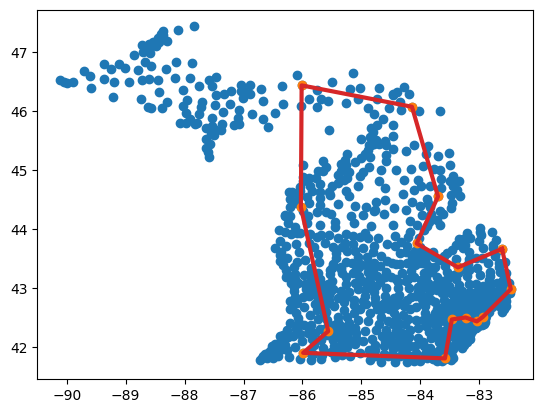

In [ ]:
tour=[]
for i in range(1,n+1):
  for j in range(n):
    if -0.1 < i - p[j].varValue < 0.1:
      tour.append(j)
tour.append(tour[0])

path=np.array([[data[mi_indices[city_list[i]]]['geo_point_2d']['lon'],data[mi_indices[city_list[i]]]['geo_point_2d']['lat']] for i in tour])

points=np.array([[data[mi_indices[i]]['geo_point_2d']['lon'],data[mi_indices[i]]['geo_point_2d']['lat']] for i in range(len(mi_indices))])
points2=np.array([[data[mi_indices[i]]['geo_point_2d']['lon'],data[mi_indices[i]]['geo_point_2d']['lat']] for i in city_list])

plt.plot(path[:,0],path[:,1], 'C3', lw=3)
plt.scatter(points[:,0],points[:,1])
plt.scatter(points2[:,0],points2[:,1])
plt.show()